# 7. Neural Machine Translation and Models with Attention

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture9.pdf
* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf
* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture11.pdf
* https://arxiv.org/pdf/1409.0473.pdf
* https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
* https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983
* http://www.manythings.org/anki/

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
flatten = lambda l: [item for sublist in l for item in sublist]

from torch.nn.utils.rnn import PackedSequence,pack_padded_sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
random.seed(1024)
%matplotlib inline

In [6]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

### Padding

<img src="../images/07.pad_to_sequence.png">
<center>borrowed image from https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983</center>

In [4]:
# It is for Sequence 2 Sequence format
def pad_to_batch(batch, x_to_ix, y_to_ix):
    
    sorted_batch =  sorted(batch, key=lambda b:b[0].size(1), reverse=True) # sort by len
    x,y = list(zip(*sorted_batch))
    max_x = max([s.size(1) for s in x])
    max_y = max([s.size(1) for s in y])
    x_p, y_p = [], []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
        if y[i].size(1) < max_y:
            y_p.append(torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1)))).view(1, -1)], 1))
        else:
            y_p.append(y[i])
        
    input_var = torch.cat(x_p)
    target_var = torch.cat(y_p)
    input_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in input_var]
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var]
    
    return input_var, target_var, input_len, target_len

In [5]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data load and Preprocessing 

Borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [6]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

<center><h3>French -> English</h3></center>

In [7]:
corpus = open('../dataset/eng-fra.txt', 'r', encoding='utf-8').readlines()

In [8]:
len(corpus)

142787

In [9]:
corpus = corpus[:30000] # for practice

In [10]:
MIN_LENGTH = 3
MAX_LENGTH = 25

In [11]:
%%time
X_r, y_r = [], [] # raw

for parallel in corpus:
    so,ta = parallel[:-1].split('\t')
    if so.strip() == "" or ta.strip() == "": 
        continue
    
    normalized_so = normalize_string(so).split()
    normalized_ta = normalize_string(ta).split()
    
    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH \
    and len(normalized_ta) >= MIN_LENGTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)
    

print(len(X_r), len(y_r))
print(X_r[0], y_r[0])

29830 29830
['i', 'see', '.'] ['je', 'comprends', '.']
CPU times: user 836 ms, sys: 8 ms, total: 844 ms
Wall time: 843 ms


### Build Vocab

In [12]:
source_vocab = list(set(flatten(X_r)))
target_vocab = list(set(flatten(y_r)))
print(len(source_vocab), len(target_vocab))

4433 7704


In [13]:
source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in source_vocab:
    if source2index.get(vo) is None:
        source2index[vo] = len(source2index)
index2source = {v:k for k, v in source2index.items()}

target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in target_vocab:
    if target2index.get(vo) is None:
        target2index[vo] = len(target2index)
index2target = {v:k for k, v in target2index.items()}

### Prepare train data

In [14]:
%%time
X_p, y_p = [], []

for so, ta in zip(X_r, y_r):
    X_p.append(prepare_sequence(so + ['</s>'], source2index).view(1, -1))
    y_p.append(prepare_sequence(ta + ['</s>'], target2index).view(1, -1))
    
train_data = list(zip(X_p, y_p))

CPU times: user 2.16 s, sys: 364 ms, total: 2.52 s
Wall time: 2.89 s


## Modeling 

<img src="../images/07.seq2seq.png">
<center>borrowd image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf</center>

If you're not familier with <strong>pack_padded_sequence</strong> and <strong>pad_packed_sequence</strong>, check this <a href="https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983">post</a>.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size,hidden_size, n_layers=1,bidirec=False):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        if bidirec:
            self.n_direction = 2 
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)
    
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers * self.n_direction, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
    
    def forward(self, inputs, input_lengths):
        """
        inputs : B, T (LongTensor)
        input_lengths : real lengths of input batch (list)
        """
        hidden = self.init_hidden(inputs)
        
        embedded = self.embedding(inputs)
        packed = pack_padded_sequence(embedded, input_lengths, batch_first=True)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True) # unpack (back to padded)
                
        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]
        
        return outputs, torch.cat([h for h in hidden], 1).unsqueeze(1)

### Attention Mechanism ( https://arxiv.org/pdf/1409.0473.pdf )

I used general-type for score function $h_t^TW_ah_s^-$

<img src="../images/07.attention-mechanism.png">
<center>borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture10.pdf</center>

In [37]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # Define the layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout_p)
        
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, input_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size) # Attention
    
    def init_hidden(self,inputs):
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)
#         self.attn.bias.data.fill_(0)
    
    def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        hidden = hidden[0].unsqueeze(2)  # (1,B,D) -> (B,D,1)
        
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) # B*T,D -> B*T,D
        energies = energies.view(batch_size,max_len, -1) # B,T,D
        attn_energies = energies.bmm(hidden).squeeze(2) # B,T,D * B,D,1 --> B,T
        
#         if isinstance(encoder_maskings,torch.autograd.variable.Variable):
#             attn_energies = attn_energies.masked_fill(encoder_maskings,float('-inf'))#-1e12) # PAD masking
        
        alpha = F.softmax(attn_energies,1) # B,T
        alpha = alpha.unsqueeze(1) # B,1,T
        context = alpha.bmm(encoder_outputs) # B,1,T * B,T,D => B,1,D
        
        return context, alpha
    
    
    def forward(self, inputs, context, max_length, encoder_outputs, encoder_maskings=None, is_training=False):
        """
        inputs : B,1 (LongTensor, START SYMBOL)
        context : B,1,D (FloatTensor, Last encoder hidden state)
        max_length : int, max length to decode # for batch
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        is_training : bool, this is because adapt dropout only training step.
        """
        # Get the embedding of the current input word
        embedded = self.embedding(inputs)
        hidden = self.init_hidden(inputs)
        if is_training:
            embedded = self.dropout(embedded)
        
        decode = []
        # Apply GRU to the output so far
        for i in range(max_length):

            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # y_t = g(h_t,y_{t-1},c)
            score = self.linear(concated.squeeze(0))
            softmaxed = F.log_softmax(score,1)
            decode.append(softmaxed)
            decoded = softmaxed.max(1)[1]
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            if is_training:
                embedded = self.dropout(embedded)
            
            # compute next context vector using attention
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_maskings)
            
        #  column-wise concat, reshape!!
        scores = torch.cat(decode, 1)
        return scores.view(inputs.size(0) * max_length, -1)
    
    def decode(self, context, encoder_outputs):
        start_decode = Variable(LongTensor([[target2index['<s>']] * 1])).transpose(0, 1)
        embedded = self.embedding(start_decode)
        hidden = self.init_hidden(start_decode)
        
        decodes = []
        attentions = []
        decoded = embedded
        while decoded.data.tolist()[0] != target2index['</s>']: # until </s>
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            concated = torch.cat((hidden, context.transpose(0, 1)), 2) # y_t = g(h_t,y_{t-1},c)
            score = self.linear(concated.squeeze(0))
            softmaxed = F.log_softmax(score,1)
            decodes.append(softmaxed)
            decoded = softmaxed.max(1)[1]
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            context, alpha = self.Attention(hidden, encoder_outputs,None)
            attentions.append(alpha.squeeze(1))
        
        return torch.cat(decodes).max(1)[1], torch.cat(attentions)

## Train 

It takes for a while if you use just cpu....

In [70]:
EPOCH = 50
BATCH_SIZE = 64
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
LR = 0.001
DECODER_LEARNING_RATIO = 5.0
RESCHEDULED = False

In [71]:
encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True)
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)
encoder.init_weight()
decoder.init_weight()

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=0)
enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)

In [72]:
for epoch in range(EPOCH):
    losses=[]
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source2index, target2index)
        
        input_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in inputs]).view(inputs.size(0), -1)
        start_decode = Variable(LongTensor([[target2index['<s>']] * targets.size(0)])).transpose(0, 1)
        encoder.zero_grad()
        decoder.zero_grad()
        output, hidden_c = encoder(inputs, input_lengths)
        
        preds = decoder(start_decode, hidden_c, targets.size(1), output, input_masks, True)
                                
        loss = loss_function(preds, targets.view(-1))
        losses.append(loss.data.tolist()[0] )
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 50.0) # gradient clipping
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 50.0) # gradient clipping
        enc_optimizer.step()
        dec_optimizer.step()

        if i % 200==0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" %(epoch, EPOCH, i, len(train_data)//BATCH_SIZE, np.mean(losses)))
            losses=[]

    # You can use http://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate
    if RESCHEDULED == False and epoch  == EPOCH//2:
        LR *= 0.01
        enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
        dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)
        RESCHEDULED = True

[00/50] [000/466] mean_loss : 8.94
[00/50] [200/466] mean_loss : 4.27
[00/50] [400/466] mean_loss : 3.38
[01/50] [000/466] mean_loss : 2.79
[01/50] [200/466] mean_loss : 2.59
[01/50] [400/466] mean_loss : 2.40
[02/50] [000/466] mean_loss : 1.86
[02/50] [200/466] mean_loss : 1.97
[02/50] [400/466] mean_loss : 1.93
[03/50] [000/466] mean_loss : 1.58
[03/50] [200/466] mean_loss : 1.61
[03/50] [400/466] mean_loss : 1.70
[04/50] [000/466] mean_loss : 1.42
[04/50] [200/466] mean_loss : 1.43
[04/50] [400/466] mean_loss : 1.48
[05/50] [000/466] mean_loss : 1.09
[05/50] [200/466] mean_loss : 1.29
[05/50] [400/466] mean_loss : 1.31
[06/50] [000/466] mean_loss : 1.00
[06/50] [200/466] mean_loss : 1.17
[06/50] [400/466] mean_loss : 1.23
[07/50] [000/466] mean_loss : 0.82
[07/50] [200/466] mean_loss : 1.07
[07/50] [400/466] mean_loss : 1.14
[08/50] [000/466] mean_loss : 1.10
[08/50] [200/466] mean_loss : 1.02
[08/50] [400/466] mean_loss : 1.09
[09/50] [000/466] mean_loss : 0.86
[09/50] [200/466] me

## Test

### Visualize Attention

In [20]:
# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

Source :  he is telling a lie .
Truth :  il dit un mensonge .
Prediction :  il dit un mensonge .


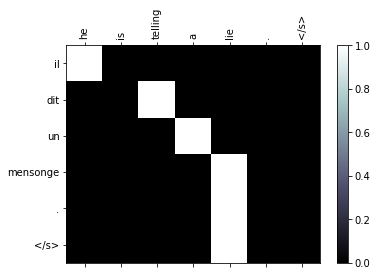

In [99]:
test = random.choice(train_data)
input_ = test[0]
truth = test[1]

output, hidden = encoder(input_, [input_.size(1)])
pred, attn = decoder.decode(hidden, output)

input_ = [index2source[i] for i in input_.data.tolist()[0]]
pred = [index2target[i] for i in pred.data.tolist()]


print('Source : ',' '.join([i for i in input_ if i not in ['</s>']]))
print('Truth : ',' '.join([index2target[i] for i in truth.data.tolist()[0] if i not in [2, 3]]))
print('Prediction : ',' '.join([i for i in pred if i not in ['</s>']]))

if USE_CUDA:
    attn = attn.cpu()

show_attention(input_, pred, attn.data)

# TODO 

* BLEU
* Beam Search
* <a href="http://www.aclweb.org/anthology/P15-1001">Sampled Softmax</a>

## Further topics

* <a href="https://s3.amazonaws.com/fairseq/papers/convolutional-sequence-to-sequence-learning.pdf">Convolutional Sequence to Sequence learning</a>
* <a href="https://arxiv.org/abs/1706.03762">Attention is all you need</a>
* <a href="https://arxiv.org/abs/1711.00043">Unsupervised Machine Translation Using Monolingual Corpora Only</a>

## Suggested Reading 

* <a href="https://arxiv.org/pdf/1709.07809.pdf">SMT chapter13. Neural Machine Translation</a>